#### Code History


 - CODE  
    &ensp; : IITP_TCN
 - DATE  
    &ensp; 2023-08-30 Created  
    &ensp; 2023-10-12 Modified (작업 재개)
 - DESC  
    &ensp; : df_raw_temp_2023-08-09.csv 데이터를 분석
 - DATA  
    1) Period : 2017-11-01 01:00:00 ~ 2021-06-30 09:00:00  
    2) Interval : 1H  
 - Link  
    &ensp; : https://github.com/ecokeco/tstl/tree/master/scripts

# 01. Code

## 01-01. Init

### 01-01-01. Init_Module Import

In [ ]:
#region Basic_Import
## Basic
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import random
from pandas import DataFrame, Series

## Datetime
import time
import datetime as dt
from datetime import datetime, date, timedelta

from glob import glob
import requests
import json

## 시각화
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

from scipy import stats

## TSNE
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE

## 정규화
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## Modeling, Model Training
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

## Model 평가
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score   # model.score   

## Excel/CSV
import openpyxl, xlrd

import urllib
from urllib.request import urlopen
from urllib.parse import urlencode, unquote, quote_plus

from selenium import webdriver
from selenium.webdriver.chrome.service import Service

from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

## Init.
pd.options.display.float_format = '{:.10f}'.format
#endregion Basic_Import

In [ ]:
## Import_DL
str_tar = "tf"
## For Torch
if str_tar == "torch":
    import torch
    import torch.nn as nn
    from torch.nn.utils import weight_norm
    print("Torch Imported")
## For TF
elif str_tar == "tf":
    import tensorflow as tf
    import tensorflow_addons as tfa
    print("Tensorflow Imported")
else:
    print("Error : Cannot be used except for Keywords")
    print(" : torch / tf")

Tensorflow Imported


In [ ]:
## LSTM
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
## Import_Local (현재 프로그램에서 미사용)
from DEV_Common_Data_Analysis import print_desc_statistic
from DEV_Common_Data_Datetime import create_col_ymdhm, create_col_datetime, create_df_dt, conv_midnight_24to00, create_col_weekdays #, validate_date, list_invalidDate, calc_df_dt
from DEV_Common_Data_Preprocessing import resample_by_last, find_outlier_Usages, del_outlier_Usages
from DEV_Common_Data_Visualization import visualization_df
from DEV_KASI_Holiday import KASI_holiDay, KASI_restDay, KASI_anniDay
from DEV_KMA_Weather_ASOS import KMA_ASOS_DATA
from DEV_KDHC_Usage import KDHC_HEAT_Usage

### 01-01-02. Config (Directory, Params)

In [ ]:
## Init_config
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = "1"
random.seed(SEED)

In [ ]:
## Define Todate str
str_now_ymd = pd.datetime.now().date()
str_now_y = pd.datetime.now().year
str_now_m = pd.datetime.now().month
str_now_d = pd.datetime.now().day
str_now_hr = pd.datetime.now().hour
str_now_min = pd.datetime.now().minute

print(pd.datetime.now())
print(str(str_now_y) + " / " + str(str_now_m)  + " / " + str(str_now_d))
print(str(str_now_hr) + " : " + str(str_now_min))

2023-12-07 02:32:15.556641
2023 / 12 / 7
2 : 32


## 01-02. Data Load (df_raw)

### 01-02-01. KDHC Heat Usage

In [ ]:
# Define data root directory
str_dir_kdhcHeat = "./data_Energy_KDHC_National_Heat/"
print(os.listdir(str_dir_kdhcHeat))

## CSV read
df_kdhc_cj = pd.read_csv(str_dir_kdhcHeat + 'KDHC_HEAT_CHEONGJU_2010_2021_1st_Check.csv')
df_kdhc_cj = df_kdhc_cj.rename(columns = {"HEAT_SELL_DATE" : "METER_DATE"})
df_kdhc_cj["METER_DATE"] = pd.to_datetime(df_kdhc_cj["METER_DATE"])
print(df_kdhc_cj.info())
df_kdhc_cj

['KDHC_COMB_HEAT-CJ_ASOS_KASI_2010-2023.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022_complete_analysis.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022_linearReg.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022_mean_imp.csv', 'KDHC_COMB_KANGNAMHEATxWEATHER_2019-2022.csv', 'KDHC_HEAT', 'KDHC_HEAT.zip', 'KDHC_HEAT_CHEONGJU_2010_2021.csv', 'KDHC_HEAT_CHEONGJU_2010_2021_1st_Check.csv', 'KDHC_HEAT_SEJONG_2014_2018.csv', 'KDHC_HEAT_SEJONG_2014_2018_1st_Check.csv', 'KDHC_NATIONAL_HEAT_hr.csv', 'KDHC_NATIONAL_HEAT_RAW_hr.csv']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105192 entries, 0 to 105191
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   METER_DATE       105192 non-null  datetime64[ns]
 1   DAY_OF_THE_WEEK  105192 non-null  object        
 2   HOUR             105192 non-null  int64         
 3   CHEONGJU         105192 non-null  float64       
 4   YEAR             10

,METER_DATE,DAY_OF_THE_WEEK,HOUR,CHEONGJU,YEAR,MONTH,DAY
0,2010-01-01 01:00:00,금,1,178.0000000000,2010,1,1
1,2010-01-01 02:00:00,금,2,170.0000000000,2010,1,1
2,2010-01-01 03:00:00,금,3,165.0000000000,2010,1,1
3,2010-01-01 04:00:00,금,4,161.0000000000,2010,1,1
4,2010-01-01 05:00:00,금,5,162.0000000000,2010,1,1
...,...,...,...,...,...,...,...
105187,2021-12-31 20:00:00,금,20,217.0000000000,2021,12,31
105188,2021-12-31 21:00:00,금,21,221.0000000000,2021,12,31
105189,2021-12-31 22:00:00,금,22,217.0000000000,2021,12,31
105190,2021-12-31 23:00:00,금,23,214.0000000000,2021,12,31


In [ ]:
# Define data root directory
str_dir_ASOS = "./data_KMA_ASOS/"
print(os.listdir(str_dir_ASOS))

## CSV read
df_asos = pd.read_csv(str_dir_ASOS + 'KMA_ASOS_131_2010-2023_Cleansed_HR.csv'
                      , index_col = 0)
df_asos["METER_DATE"] = pd.to_datetime(df_asos["METER_DATE"])
print(df_asos.info())
df_asos

['ASOS_108_2010.csv', 'ASOS_108_2010_D.csv', 'ASOS_108_2011.csv', 'ASOS_108_2011_D.csv', 'ASOS_108_2012.csv', 'ASOS_108_2012_D.csv', 'ASOS_108_2013.csv', 'ASOS_108_2013_D.csv', 'ASOS_108_2014.csv', 'ASOS_108_2014_D.csv', 'ASOS_108_2015.csv', 'ASOS_108_2015_D.csv', 'ASOS_108_2016.csv', 'ASOS_108_2016_D.csv', 'ASOS_108_2017.csv', 'ASOS_108_2017_D.csv', 'ASOS_108_2018.csv', 'ASOS_108_2018_D.csv', 'ASOS_108_2019.csv', 'ASOS_108_2019_D.csv', 'ASOS_108_2020.csv', 'ASOS_108_2020_D.csv', 'ASOS_108_2021.csv', 'ASOS_108_2021_D.csv', 'ASOS_108_2022.csv', 'ASOS_108_2022_D.csv', 'ASOS_108_2023.csv', 'ASOS_108_2023_D.csv', 'ASOS_119_2010.csv', 'ASOS_119_2010_D.csv', 'ASOS_119_2011.csv', 'ASOS_119_2011_D.csv', 'ASOS_119_2012.csv', 'ASOS_119_2012_D.csv', 'ASOS_119_2013.csv', 'ASOS_119_2013_D.csv', 'ASOS_119_2014.csv', 'ASOS_119_2014_D.csv', 'ASOS_119_2015.csv', 'ASOS_119_2015_D.csv', 'ASOS_119_2016.csv', 'ASOS_119_2016_D.csv', 'ASOS_119_2017.csv', 'ASOS_119_2017_D.csv', 'ASOS_119_2018.csv', 'ASOS_119_

,METER_DATE,temp_outdoor,temp_dew_point,temp_ground,humidity,rainfall,snowfall,snowfall_3hr,wind_speed,wind_direction,pressure_vapor,pressure_area,pressure_sea,sunshine,solar_radiation,cloud_total,cloud_midlow,visual_range
0,2010-01-01 00:00:00,-9.0000000000,-18.0000000000,-8.0000000000,48.0000000000,0.0000000000,0.0000000000,0.0000000000,0.9000000000,320.0000000000,1.5000000000,1016.2000000000,1023.6000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,1800.0000000000
1,2010-01-01 01:00:00,-9.0000000000,-17.3000000000,-7.0000000000,51.0000000000,0.0000000000,0.0000000000,0.0000000000,1.1000000000,250.0000000000,1.6000000000,1016.4000000000,1023.8000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
2,2010-01-01 02:00:00,-9.3000000000,-15.6000000000,-6.1000000000,60.0000000000,0.0000000000,0.0000000000,0.0000000000,0.9000000000,340.0000000000,1.8000000000,1016.6000000000,1024.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
3,2010-01-01 03:00:00,-9.2000000000,-15.5000000000,-6.0000000000,60.0000000000,0.0000000000,0.0000000000,0.0000000000,0.2000000000,0.0000000000,1.8000000000,1016.9000000000,1024.3000000000,0.0000000000,0.0000000000,7.0000000000,7.0000000000,1800.0000000000
4,2010-01-01 04:00:00,-9.7000000000,-15.0000000000,-7.5000000000,65.0000000000,0.0000000000,0.0000000000,0.0000000000,0.5000000000,340.0000000000,1.9000000000,1016.5000000000,1023.9000000000,0.0000000000,0.0000000000,2.0000000000,2.0000000000,1800.0000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5275,2023-08-08 19:00:00,30.6000000000,25.1000000000,30.1000000000,73.0000000000,0.0000000000,0.0000000000,0.0000000000,1.3000000000,50.0000000000,31.9000000000,995.0000000000,1001.5000000000,0.0000000000,0.2800000000,8.0000000000,8.0000000000,3628.0000000000
5276,2023-08-08 20:00:00,30.8000000000,24.4000000000,29.5000000000,69.0000000000,0.0000000000,0.0000000000,0.0000000000,1.1000000000,20.0000000000,30.6000000000,995.5000000000,1002.0000000000,0.0000000000,0.0100000000,8.0000000000,8.0000000000,5000.0000000000
5277,2023-08-08 21:00:00,31.3000000000,22.8000000000,29.1000000000,61.0000000000,0.0000000000,0.0000000000,0.0000000000,1.6000000000,70.0000000000,27.7000000000,995.9000000000,1002.4000000000,0.0000000000,0.0000000000,7.0000000000,7.0000000000,5000.0000000000
5278,2023-08-08 22:00:00,31.0000000000,22.5000000000,28.6000000000,61.0000000000,0.0000000000,0.0000000000,0.0000000000,2.1000000000,70.0000000000,27.2000000000,995.9000000000,1002.4000000000,0.0000000000,0.0000000000,7.0000000000,7.0000000000,5000.0000000000


In [ ]:
# Define data root directory
str_dir_KASI = "./data_Date_KASI/"
# print(os.listdir(str_dir_KASI))

## CSV read
df_kasi = pd.read_csv(str_dir_KASI + 'KASI_04-01_holiDay_distAdded_hr.csv')
df_kasi = df_kasi.rename(columns = {"DATETIME" : "METER_DATE"})
df_kasi = df_kasi[['METER_DATE', 'YEAR', 'MONTH', 'DAY', 'code_day_of_the_week', 'dist_from_holiday'
                   , 'HOUR', 'rest_YN']]
print(df_kasi.info())
df_kasi

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122690 entries, 0 to 122689
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   METER_DATE            122690 non-null  object
 1   YEAR                  122690 non-null  int64 
 2   MONTH                 122690 non-null  int64 
 3   DAY                   122690 non-null  int64 
 4   code_day_of_the_week  122690 non-null  int64 
 5   dist_from_holiday     122690 non-null  object
 6   HOUR                  122690 non-null  int64 
 7   rest_YN               122690 non-null  object
dtypes: int64(5), object(3)
memory usage: 7.5+ MB
None


,METER_DATE,YEAR,MONTH,DAY,code_day_of_the_week,dist_from_holiday,HOUR,rest_YN
0,2010-01-01 00:00:00,2010,1,1,4,0,0,1
1,2010-01-01 01:00:00,2010,1,1,4,23,1,0
2,2010-01-01 02:00:00,2010,1,1,4,22,2,0
3,2010-01-01 03:00:00,2010,1,1,4,21,3,0
4,2010-01-01 04:00:00,2010,1,1,4,20,4,0
...,...,...,...,...,...,...,...,...
122685,2023-12-30 20:00:00,2023,12,30,5,0,20,1
122686,2023-12-30 21:00:00,2023,12,30,5,0,21,1
122687,2023-12-30 22:00:00,2023,12,30,5,0,22,1
122688,2023-12-30 23:00:00,2023,12,30,5,0,23,1


In [ ]:
df_kasi.columns

Index(['METER_DATE', 'YEAR', 'MONTH', 'DAY', 'code_day_of_the_week',
       'dist_from_holiday', 'HOUR', 'rest_YN'],
      dtype='object')

In [ ]:
date_kdhc_cj = pd.to_datetime(df_kdhc_cj["METER_DATE"])
dt_kdhc_cj_start = date_kdhc_cj.min()
dt_kdhc_cj_end = date_kdhc_cj.max()
print(dt_kdhc_cj_start)
print(dt_kdhc_cj_end)

date_asos = pd.to_datetime(df_asos["METER_DATE"])
date_asos_start = date_asos.min()
date_asos_end = date_asos.max()
print(date_asos_start)
print(date_asos_end)

date_kasi = pd.to_datetime(df_kasi["METER_DATE"])
date_kasi_start = date_kasi.min()
date_kasi_end = date_kasi.max()
print(date_kasi_start)
print(date_kasi_end)

2010-01-01 01:00:00
2022-01-01 00:00:00
2010-01-01 00:00:00
2023-08-08 23:00:00
2010-01-01 00:00:00
2023-12-31 00:00:00


In [ ]:
dt_start = max(dt_kdhc_cj_start, date_asos_start, date_kasi_start)
print(dt_start)
dt_end = max(dt_kdhc_cj_end, date_asos_end, date_kasi_end)
print(dt_end)

2010-01-01 01:00:00
2023-12-31 00:00:00


In [ ]:
df_dt = pd.DataFrame()
df_dt = create_df_dt(df_dt, "METER_DATE", dt_start, dt_end, "1H")
df_dt

,METER_DATE,day_of_the_week,YEAR,MONTH,DAY,HOUR,MINUTE,code_day_of_the_week
0,2010-01-01 01:00:00,Friday,2010,1,1,1,0,4
1,2010-01-01 02:00:00,Friday,2010,1,1,2,0,4
2,2010-01-01 03:00:00,Friday,2010,1,1,3,0,4
3,2010-01-01 04:00:00,Friday,2010,1,1,4,0,4
4,2010-01-01 05:00:00,Friday,2010,1,1,5,0,4
...,...,...,...,...,...,...,...,...
122683,2023-12-30 20:00:00,Saturday,2023,12,30,20,0,5
122684,2023-12-30 21:00:00,Saturday,2023,12,30,21,0,5
122685,2023-12-30 22:00:00,Saturday,2023,12,30,22,0,5
122686,2023-12-30 23:00:00,Saturday,2023,12,30,23,0,5


In [ ]:
print(df_kdhc_cj.columns)
print(df_asos.columns)
print(df_kasi.columns)
print(df_dt.columns)

Index(['METER_DATE', 'DAY_OF_THE_WEEK', 'HOUR', 'CHEONGJU', 'YEAR', 'MONTH',
       'DAY'],
      dtype='object')
Index(['METER_DATE', 'temp_outdoor', 'temp_dew_point', 'temp_ground',
       'humidity', 'rainfall', 'snowfall', 'snowfall_3hr', 'wind_speed',
       'wind_direction', 'pressure_vapor', 'pressure_area', 'pressure_sea',
       'sunshine', 'solar_radiation', 'cloud_total', 'cloud_midlow',
       'visual_range'],
      dtype='object')
Index(['METER_DATE', 'YEAR', 'MONTH', 'DAY', 'code_day_of_the_week',
       'dist_from_holiday', 'HOUR', 'rest_YN'],
      dtype='object')
Index(['METER_DATE', 'day_of_the_week', 'YEAR', 'MONTH', 'DAY', 'HOUR',
       'MINUTE', 'code_day_of_the_week'],
      dtype='object')


In [ ]:
df_kdhc_cj = df_kdhc_cj[['METER_DATE', 'YEAR', 'MONTH', 'DAY'
                         , 'HOUR', 'CHEONGJU']]

df_kdhc_cj["METER_DATE"] = pd.to_datetime(df_kdhc_cj["METER_DATE"])
df_asos["METER_DATE"] = pd.to_datetime(df_asos["METER_DATE"])
df_kasi["METER_DATE"] = pd.to_datetime(df_kasi["METER_DATE"])
df_dt["METER_DATE"] = pd.to_datetime(df_dt["METER_DATE"])

df_merge = pd.DataFrame()
df_merge = pd.merge(df_dt, df_kasi
                    , how = 'left', on = ['METER_DATE', 'YEAR', 'MONTH', 'DAY', 'code_day_of_the_week'
                                          , 'HOUR'])
df_merge = pd.merge(df_merge, df_asos
                    , how = 'left', on = ['METER_DATE'])
df_merge = pd.merge(df_merge, df_kdhc_cj
                    , how = 'left', on = ['METER_DATE', 'YEAR', 'MONTH', 'DAY'
                                          , 'HOUR'])
df_merge.columns

Index(['METER_DATE', 'day_of_the_week', 'YEAR', 'MONTH', 'DAY', 'HOUR',
       'MINUTE', 'code_day_of_the_week', 'dist_from_holiday', 'rest_YN',
       'temp_outdoor', 'temp_dew_point', 'temp_ground', 'humidity', 'rainfall',
       'snowfall', 'snowfall_3hr', 'wind_speed', 'wind_direction',
       'pressure_vapor', 'pressure_area', 'pressure_sea', 'sunshine',
       'solar_radiation', 'cloud_total', 'cloud_midlow', 'visual_range',
       'CHEONGJU'],
      dtype='object')

In [ ]:
## Export
df_merge.to_csv(str_dir_kdhcHeat + "KDHC_COMB_HEAT-CJ_ASOS_KASI_2010-2023.csv")

In [ ]:
df_merge = pd.read_csv(str_dir_kdhcHeat + "KDHC_COMB_HEAT-CJ_ASOS_KASI_2010-2023.csv"
                       , index_col = 0)
df_raw = df_merge
df_raw

,METER_DATE,day_of_the_week,YEAR,MONTH,DAY,HOUR,MINUTE,code_day_of_the_week,dist_from_holiday,rest_YN,...,wind_direction,pressure_vapor,pressure_area,pressure_sea,sunshine,solar_radiation,cloud_total,cloud_midlow,visual_range,CHEONGJU
0,2010-01-01 01:00:00,Friday,2010,1,1,1,0,4,23,0,...,250.0000000000,1.6000000000,1016.4000000000,1023.8000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,178.0000000000
1,2010-01-01 02:00:00,Friday,2010,1,1,2,0,4,22,0,...,340.0000000000,1.8000000000,1016.6000000000,1024.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,170.0000000000
2,2010-01-01 03:00:00,Friday,2010,1,1,3,0,4,21,0,...,0.0000000000,1.8000000000,1016.9000000000,1024.3000000000,0.0000000000,0.0000000000,7.0000000000,7.0000000000,1800.0000000000,165.0000000000
3,2010-01-01 04:00:00,Friday,2010,1,1,4,0,4,20,0,...,340.0000000000,1.9000000000,1016.5000000000,1023.9000000000,0.0000000000,0.0000000000,2.0000000000,2.0000000000,1800.0000000000,161.0000000000
4,2010-01-01 05:00:00,Friday,2010,1,1,5,0,4,19,0,...,0.0000000000,1.9000000000,1016.2000000000,1023.7000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,1800.0000000000,162.0000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127067,2023-12-30 20:00:00,Saturday,2023,12,30,20,0,5,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127068,2023-12-30 21:00:00,Saturday,2023,12,30,21,0,5,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127069,2023-12-30 22:00:00,Saturday,2023,12,30,22,0,5,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127070,2023-12-30 23:00:00,Saturday,2023,12,30,23,0,5,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 1-2-2. Data 시각화 (1차)

In [ ]:
## Date의 형식을 datetime으로 변경
date = pd.to_datetime(df_raw['METER_DATE'])
date

0        2010-01-01 01:00:00
1        2010-01-01 02:00:00
2        2010-01-01 03:00:00
3        2010-01-01 04:00:00
4        2010-01-01 05:00:00
                 ...        
127067   2023-12-30 20:00:00
127068   2023-12-30 21:00:00
127069   2023-12-30 22:00:00
127070   2023-12-30 23:00:00
127071   2023-12-31 00:00:00
Name: METER_DATE, Length: 127072, dtype: datetime64[ns]

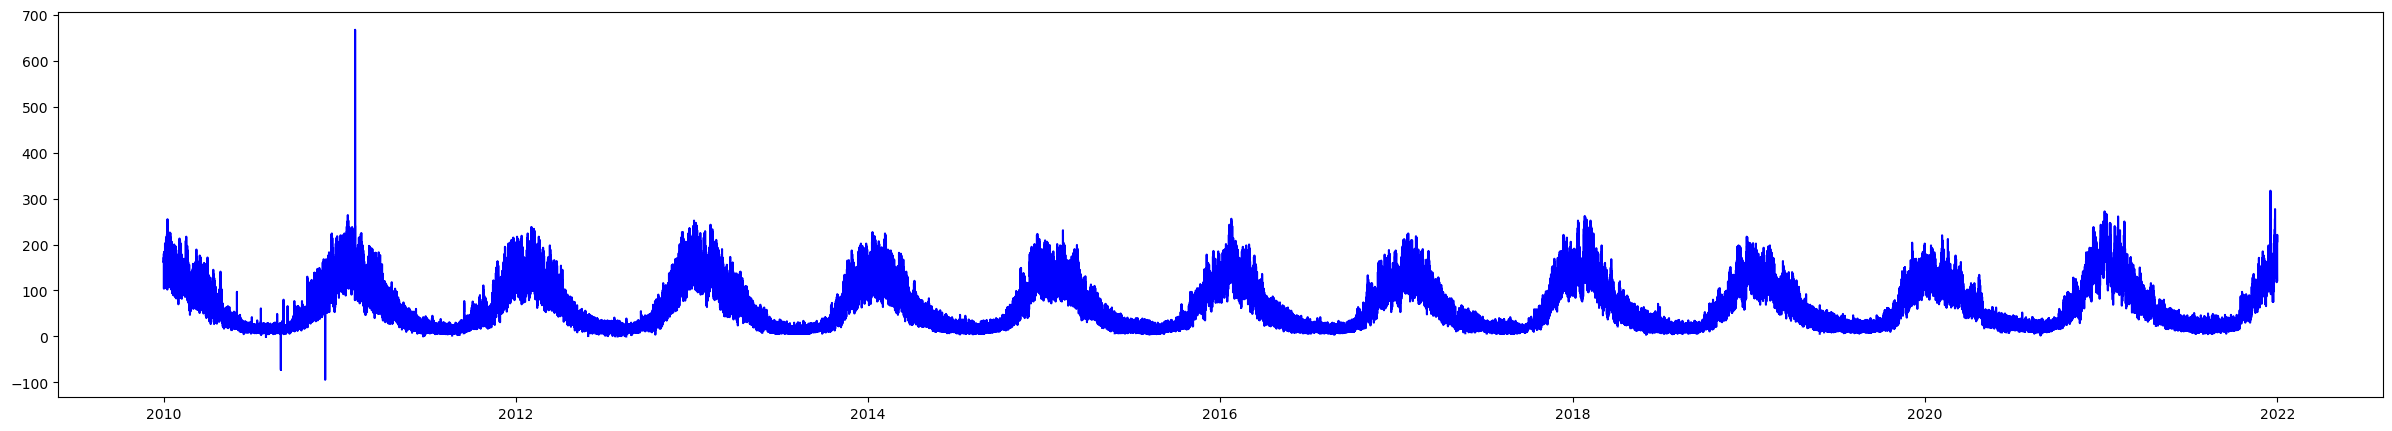

In [ ]:
## 시각화
fig, ax1 = plt.subplots(figsize=(30,5))
ax1.plot(date, df_raw['CHEONGJU'], color='blue')
plt.show()

#### 1-2-3. Data 이상치 처리

In [ ]:
## 이상치 기준 생성

## Q3 : 100개의 데이터로 가정 시, 25번째로 높은 값에 해당
## Q1 : 100개의 데이터로 가정 시, 75번째로 높은 값에 해당
## IQR : Q3 - Q1의 차이를 의미
## 이상치 : Q3 + 1.5 * IQR보다 높거나 Q1 - 1.5 * IQR보다 낮은 값을 의미

q3_df_raw = df_raw['CHEONGJU'].quantile(0.90)
q1_df_raw = df_raw['CHEONGJU'].quantile(0.25)
iqr_df_raw = q3_df_raw - q1_df_raw
print(q3_df_raw)
print(q1_df_raw)

149.0
23.0


In [ ]:
for i in range(0, len(df_raw)):
    outlier_usage = df_raw['CHEONGJU'].iloc[i]
    if ((outlier_usage > (q3_df_raw + 1.5 * iqr_df_raw)) or (outlier_usage < q1_df_raw - 1.5 * iqr_df_raw)):
        print(outlier_usage)
        df_raw['CHEONGJU'].iloc[i] = (df_raw['CHEONGJU'].iloc[i - 1] + df_raw['CHEONGJU'].iloc[i + 1]) / 2
    if outlier_usage < 0:
        print(outlier_usage)
        df_raw['CHEONGJU'].iloc[i] = 0

-0.7
-72.3
-72.3
-71.3
-72.3
-94.2
667.0


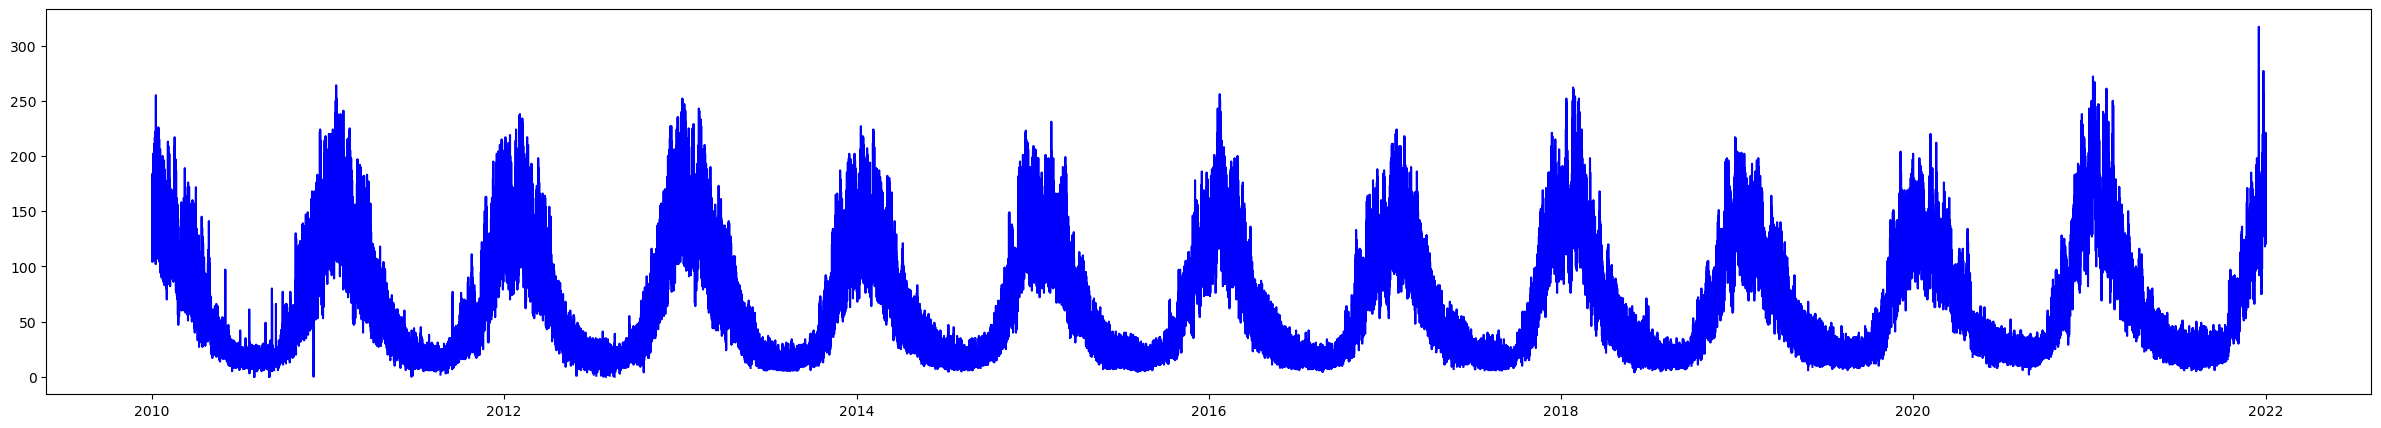

In [ ]:
## 시각화
fig, ax1 = plt.subplots(figsize=(30,5))
ax1.plot(date, df_raw['CHEONGJU'], color='blue')
plt.show()

In [ ]:
df_raw = df_raw.dropna()
df_raw['CHEONGJU'] = df_raw['CHEONGJU'].interpolate()

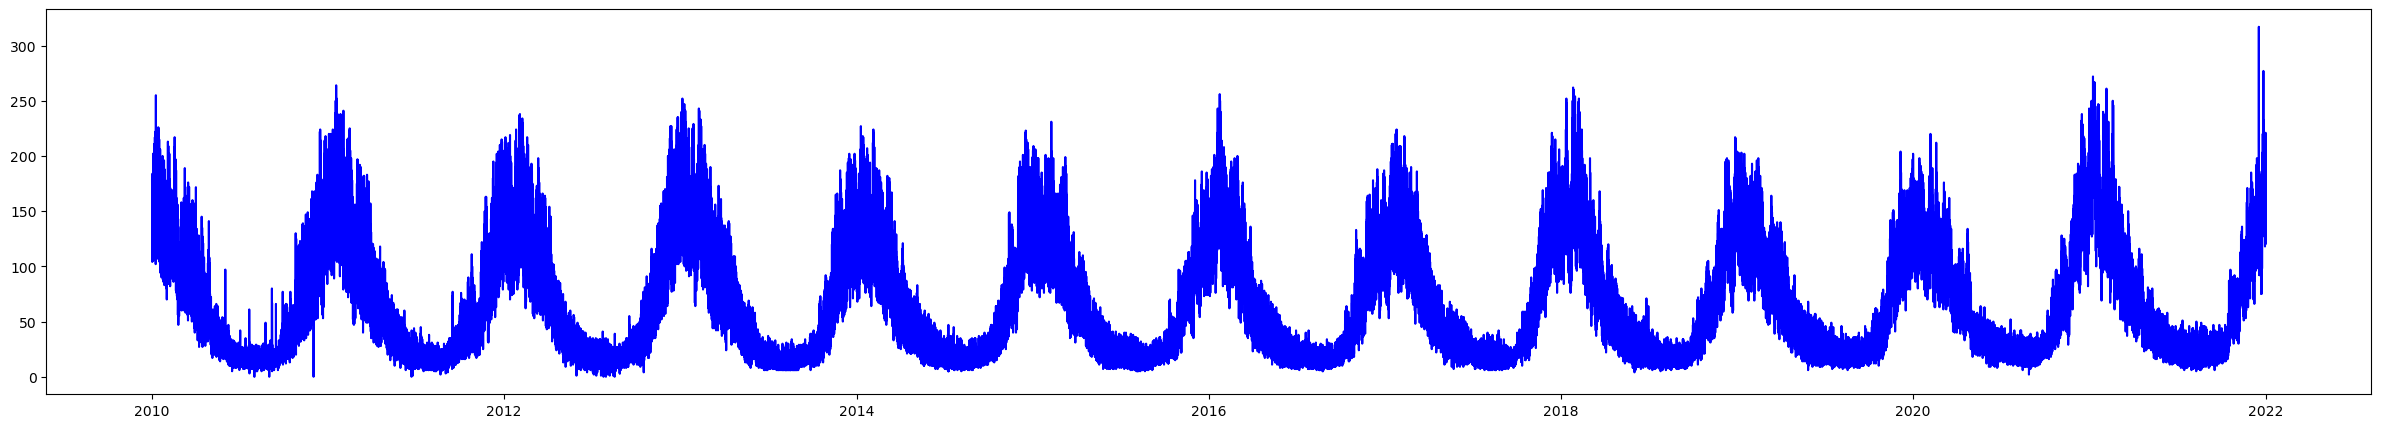

In [ ]:
## Date의 형식을 datetime으로 변경
date = pd.to_datetime(df_raw['METER_DATE'])
date

## 시각화
fig, ax1 = plt.subplots(figsize=(30,5))
ax1.plot(date, df_raw['CHEONGJU'], color='blue')
plt.show()

#### 1-2-4. Data 변수형 정리

In [ ]:
df_raw_temp = pd.DataFrame(df_raw)

df_raw_temp['METER_DATE'] = pd.to_datetime(df_raw_temp['METER_DATE'])

df_raw_temp[(df_raw_temp['rest_YN'] == 'N')]['rest_YN'] = 0
df_raw_temp[(df_raw_temp['rest_YN'] == 'Y')]['rest_YN'] = 1

for i in range(0, len(df_raw_temp)):
    if((str(df_raw_temp['rest_YN'].iloc[i]) == 'N') | (df_raw_temp['rest_YN'].iloc[i] == '0')):
        df_raw_temp['rest_YN'].iloc[i] = 0
    if((str(df_raw_temp['rest_YN'].iloc[i]) == 'Y') | (df_raw_temp['rest_YN'].iloc[i] == '1')):
        df_raw_temp['rest_YN'].iloc[i] = 1

    if((str(df_raw_temp['dist_from_holiday'].iloc[i]) == '제헌절')
        | (str(df_raw_temp['dist_from_holiday'].iloc[i]) == '한글날')):
        df_raw_temp['dist_from_holiday'].iloc[i] = 0

In [ ]:
df_raw_temp['rest_YN'] = pd.to_numeric(df_raw_temp['rest_YN'])
df_raw_temp['rest_YN'] = df_raw_temp['rest_YN'].apply(pd.to_numeric)

df_raw_temp['rest_YN'] = df_raw_temp['rest_YN'].astype('int32')

In [ ]:
df_raw_temp = df_raw_temp.dropna()

## Train 중 오류
## ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type Timestamp).
## Train 전 오류
## ValueError: DataFrame.dtypes for data must be int, float or bool.
## Did not expect the data types in the following fields: DHW_METER_DATE, day_of_the_week, name_of_holiday
## 형식에 맞지 않는 열이 앞의 Preprocessing 단계에서 제거되어야 함.
## 1차
df_raw_temp = df_raw_temp[['YEAR', 'MONTH', 'DAY', 'code_day_of_the_week', 'dist_from_holiday', 'rest_YN'
                           , 'HOUR'
                           , 'temp_outdoor', 'temp_dew_point', 'temp_ground'
                           , 'humidity'
                           , 'rainfall', 'snowfall', 'snowfall_3hr'
                           , 'wind_speed', 'wind_direction'
                           , 'pressure_vapor', 'pressure_area', 'pressure_sea'
                           , 'sunshine'
                           , 'solar_radiation'
                           , 'cloud_total', 'cloud_midlow', 'visual_range'
                           , 'CHEONGJU']]

## 2차 YD, Dist 제거
# df_raw_temp = df_raw_temp[['MONTH', 'code_day_of_the_week', 'rest_YN'
#                            , 'HOUR'
#                            , 'temp_outdoor', 'temp_dew_point', 'temp_ground'
#                            , 'humidity'
#                            , 'rainfall', 'snowfall', 'snowfall_3hr'
#                            , 'wind_speed', 'wind_direction'
#                            , 'pressure_vapor', 'pressure_area', 'pressure_sea'
#                            , 'sunshine'
#                            , 'solar_radiation'
#                            , 'cloud_total', 'cloud_midlow', 'visual_range'
#                            , 'CHEONGJU']]

## 3차 YD, Code_day_of_the_week 제거
# df_raw_temp = df_raw_temp[['MONTH', 'dist_from_holiday', 'rest_YN'
#                            , 'HOUR'
#                            , 'temp_outdoor', 'temp_dew_point', 'temp_ground'
#                            , 'humidity'
#                            , 'rainfall', 'snowfall', 'snowfall_3hr'
#                            , 'wind_speed', 'wind_direction'
#                            , 'pressure_vapor', 'pressure_area', 'pressure_sea'
#                            , 'sunshine'
#                            , 'solar_radiation'
#                            , 'cloud_total', 'cloud_midlow', 'visual_range'
#                            , 'CHEONGJU']]

df_raw_temp['dist_from_holiday'] = df_raw_temp['dist_from_holiday'].astype("int64")


## 01-03. Data Analysis

### 01-03-01. Correlation

In [ ]:
## 상관관계 분석
## 상관관계 변수 생성
df_corr = df_raw_temp.corr()
df_corr.corr()

,YEAR,MONTH,DAY,code_day_of_the_week,dist_from_holiday,rest_YN,HOUR,temp_outdoor,temp_dew_point,temp_ground,...,wind_direction,pressure_vapor,pressure_area,pressure_sea,sunshine,solar_radiation,cloud_total,cloud_midlow,visual_range,CHEONGJU
YEAR,1.0000000000,-0.0608484344,-0.0523661399,-0.0285145040,0.0171597451,-0.0415647983,-0.0198044537,0.0302833874,-0.0213512450,0.0403484958,...,-0.1680784855,-0.0309013981,0.0008138242,0.0020798985,0.0820036516,0.0786448740,0.0481622542,0.0336230719,0.5179354934,-0.0158292586
MONTH,-0.0608484344,1.0000000000,-0.0312560243,-0.0279894741,0.0271728717,-0.0365502821,-0.1234207931,0.4763493314,0.5531490277,0.4260261649,...,-0.2795273279,0.5386625372,-0.4069630878,-0.4099592218,-0.1697802640,-0.0766873476,0.2470078069,0.2177075879,-0.0498178046,-0.5221270442
DAY,-0.0523661399,-0.0312560243,1.0000000000,-0.0243502015,0.0280099949,-0.0321171611,-0.0508657524,-0.0340241971,-0.0307144051,-0.0481924868,...,-0.0460446494,-0.0383017834,0.0371059858,0.0368904966,-0.0510232400,-0.0642130798,-0.0636817471,-0.0646442121,-0.0669012633,0.0209413072
code_day_of_the_week,-0.0285145040,-0.0279894741,-0.0243502015,1.0000000000,-0.9899085018,0.9695092505,0.0338154988,-0.0197226538,-0.0237238248,-0.0272224485,...,-0.0487496775,-0.0274827557,0.0369481142,0.0362664175,-0.0168327582,-0.0241409543,-0.0530132572,-0.0560946364,-0.0348276014,0.0172338139
dist_from_holiday,0.0171597451,0.0271728717,0.0280099949,-0.9899085018,1.0000000000,-0.9392316736,-0.1411092778,0.0055137173,0.0301804982,0.0078488635,...,0.0085575181,0.0335497604,-0.0355385820,-0.0344288536,-0.0335487485,-0.0242700958,0.0787077254,0.0826303658,-0.0062518025,-0.0130042500
rest_YN,-0.0415647983,-0.0365502821,-0.0321171611,0.9695092505,-0.9392316736,1.0000000000,0.0019065464,-0.0237667041,-0.0232166131,-0.0350227513,...,-0.0695505038,-0.0283408763,0.0359723154,0.0354242618,-0.0357867067,-0.0440481828,-0.0589958241,-0.0645167317,-0.0542513360,0.0173048146
HOUR,-0.0198044537,-0.1234207931,-0.0508657524,0.0338154988,-0.1411092778,0.0019065464,1.0000000000,0.1447611327,-0.0523949614,0.1738802371,...,0.3387704244,-0.0547454784,-0.0639458848,-0.0670456985,0.4020757689,0.3928815057,-0.2608309634,-0.2828562718,0.2987859488,-0.0567705112
temp_outdoor,0.0302833874,0.4763493314,-0.0340241971,-0.0197226538,0.0055137173,-0.0237667041,0.1447611327,1.0000000000,0.9473653236,0.9890887972,...,-0.0987146892,0.9433622184,-0.9572952592,-0.9601799160,0.1916577989,0.4378815143,0.4725622103,0.3549582758,0.2612750716,-0.9921600153
temp_dew_point,-0.0213512450,0.5531490277,-0.0307144051,-0.0237238248,0.0301804982,-0.0232166131,-0.0523949614,0.9473653236,1.0000000000,0.9006898534,...,-0.2439203083,0.9986492356,-0.9615513440,-0.9624837264,-0.0992324755,0.1598079043,0.6241857060,0.5339637354,0.0285629457,-0.9529911162
temp_ground,0.0403484958,0.4260261649,-0.0481924868,-0.0272224485,0.0078488635,-0.0350227513,0.1738802371,0.9890887972,0.9006898534,1.0000000000,...,-0.0482382668,0.8959844166,-0.9292852953,-0.9327273256,0.3229051225,0.5608320445,0.4142357483,0.2892093707,0.3356585002,-0.9798162317


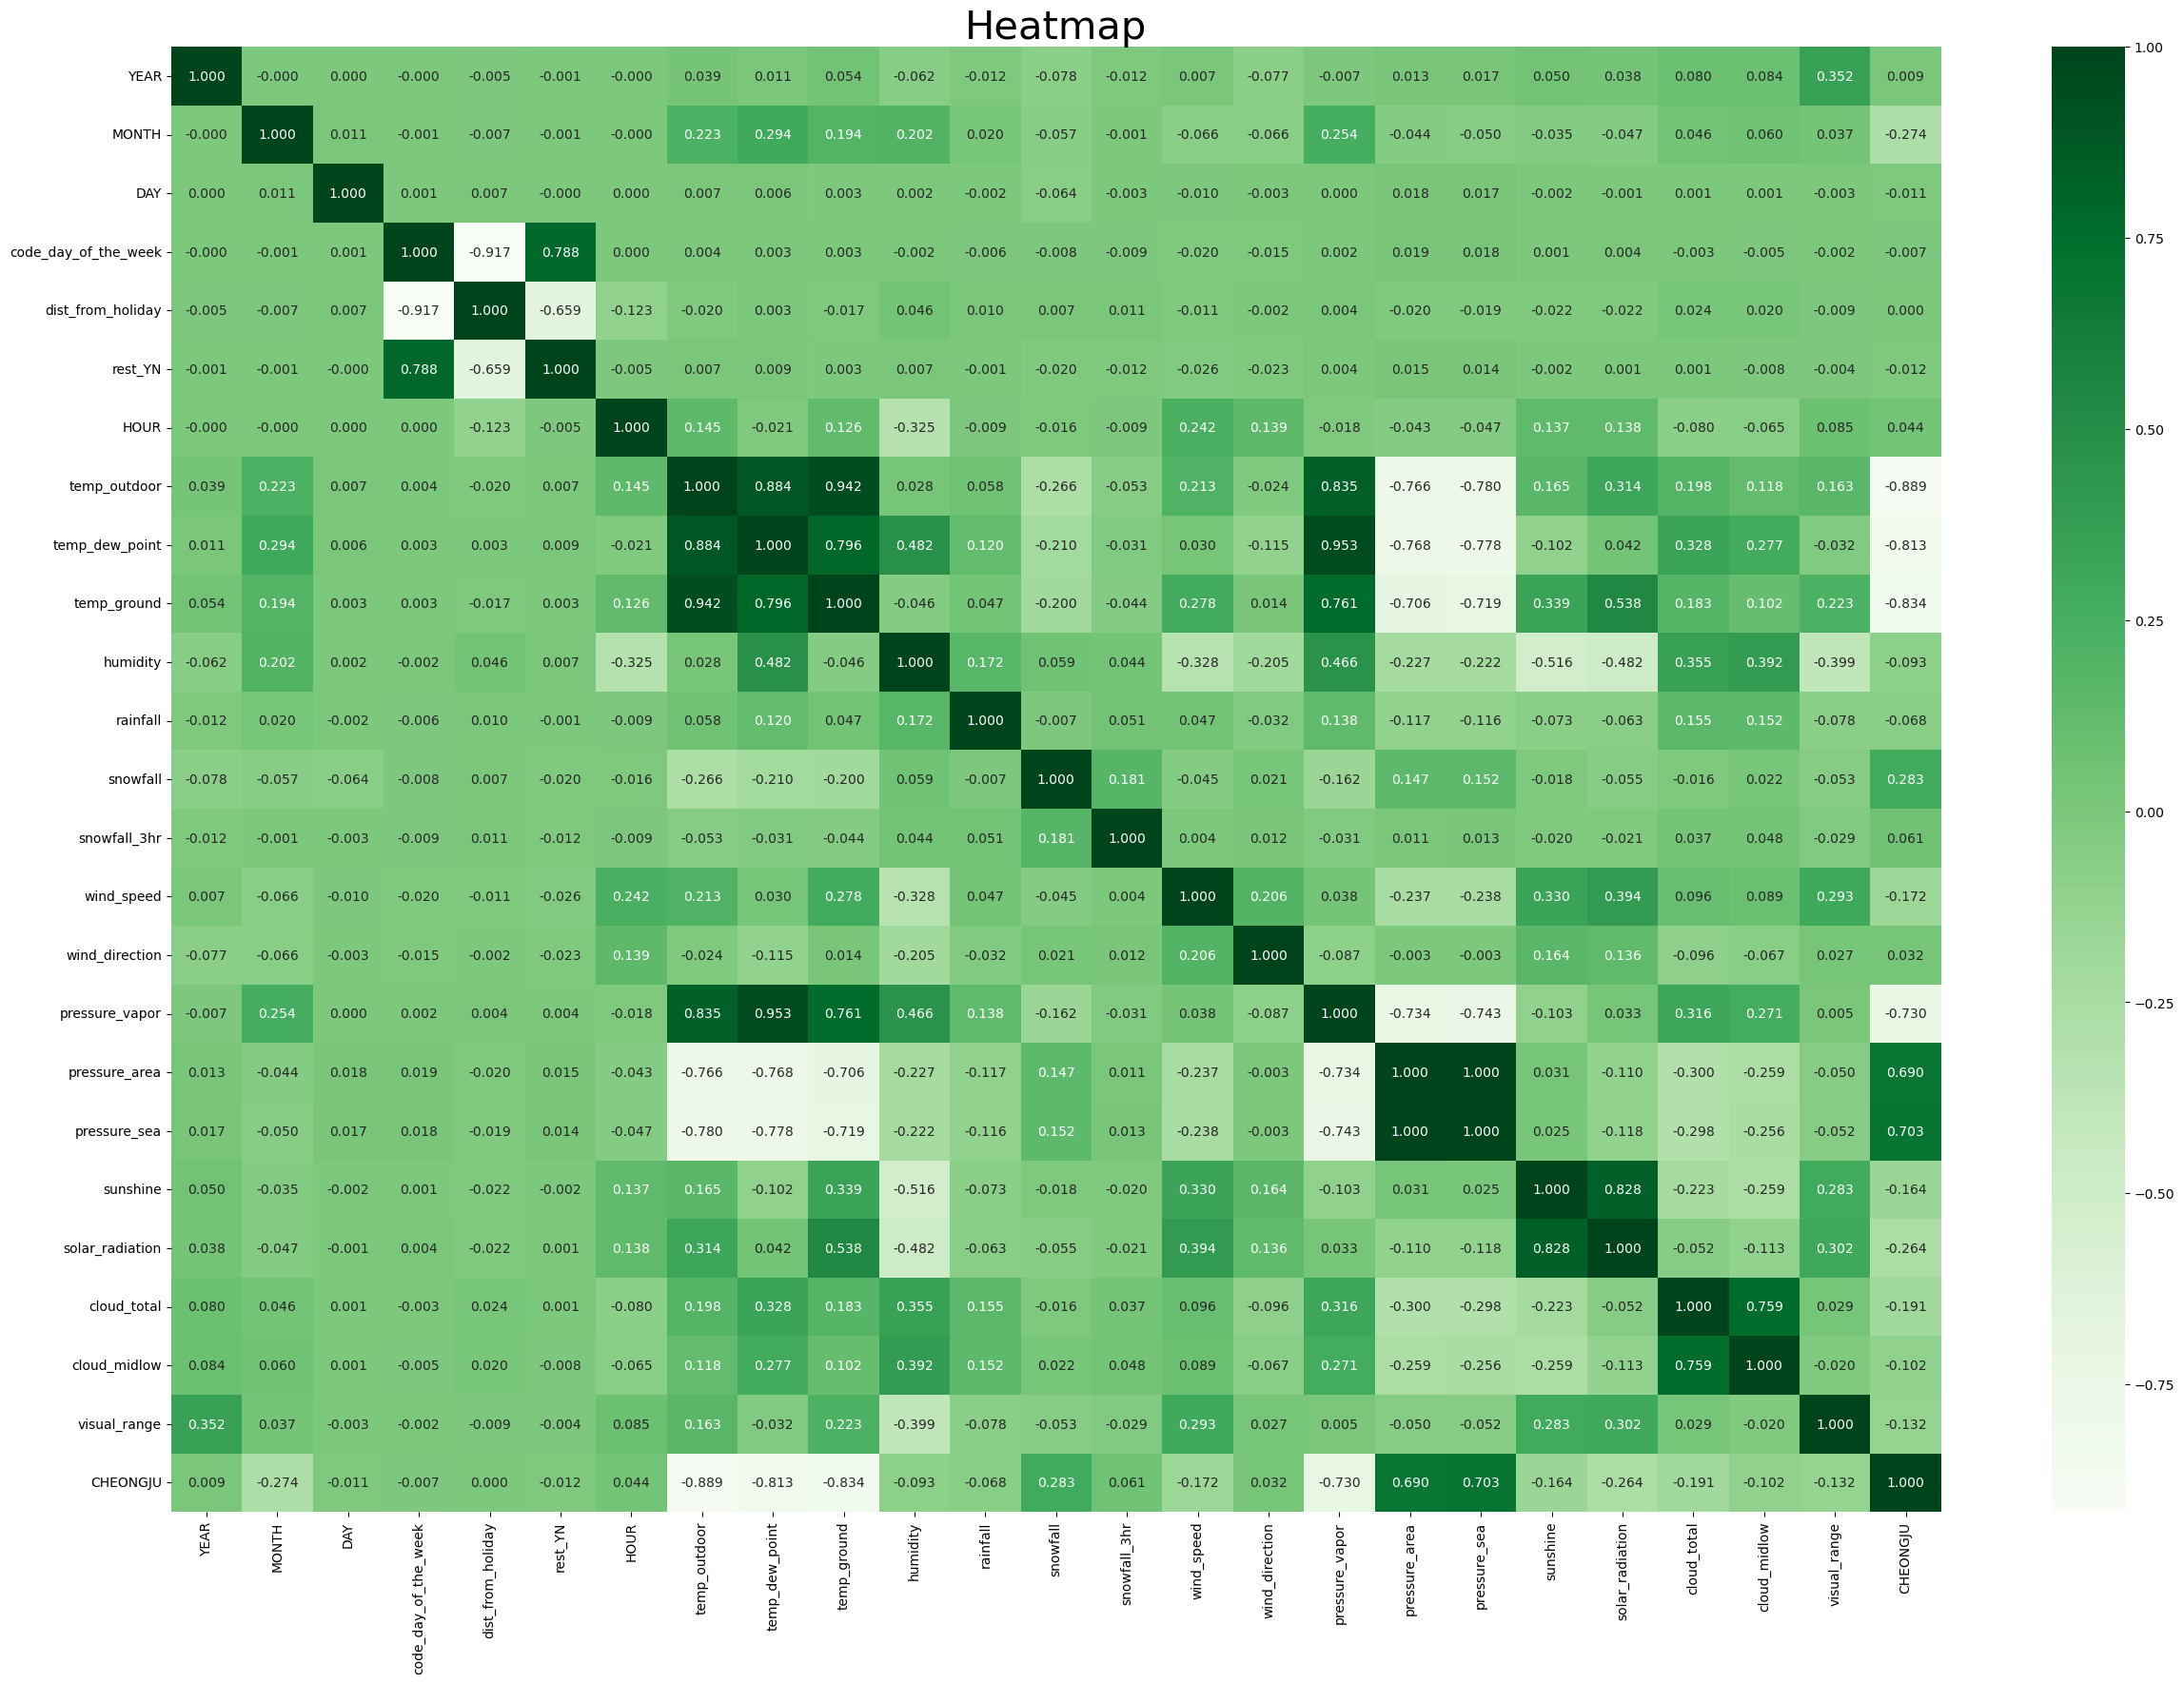

In [ ]:
## Heatmap 분석
plt.figure(figsize=(30,20))
ax = sns.heatmap(df_corr, annot=True, fmt='.3f', cmap='Greens')
plt.title("Heatmap", fontsize=30)
plt.show()

#### 1-3-1. Data Split (Train/Test Setting)

In [ ]:
print(df_raw_temp.columns)
print(df_raw_temp.info())

Index(['YEAR', 'MONTH', 'DAY', 'code_day_of_the_week', 'dist_from_holiday',
       'rest_YN', 'HOUR', 'temp_outdoor', 'temp_dew_point', 'temp_ground',
       'humidity', 'rainfall', 'snowfall', 'snowfall_3hr', 'wind_speed',
       'wind_direction', 'pressure_vapor', 'pressure_area', 'pressure_sea',
       'sunshine', 'solar_radiation', 'cloud_total', 'cloud_midlow',
       'visual_range', 'CHEONGJU'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 105191 entries, 0 to 109575
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   YEAR                  105191 non-null  int64  
 1   MONTH                 105191 non-null  int64  
 2   DAY                   105191 non-null  int64  
 3   code_day_of_the_week  105191 non-null  int64  
 4   dist_from_holiday     105191 non-null  int64  
 5   rest_YN               105191 non-null  int32  
 6   HOUR                  105191 non-null  in

### 1-5-1. DATA 분할

In [ ]:
trainSet_Origin, testSet_Origin = train_test_split(df_raw_temp, test_size=0.3, shuffle=False)
print(trainSet_Origin.shape, testSet_Origin.shape)

(73633, 25) (31558, 25)


In [ ]:
#### Data Split (Holiday YN)

## TrainSet으로부터 휴일 데이터만을 분리
print(trainSet_Origin.shape)
trainSet = trainSet_Origin

# ## 휴일일 때만
# trainSet = trainSet_Origin[(trainSet_Origin['rest_YN'] == 1)]
# trainSet = trainSet.drop(['rest_YN'], axis = 1)
print(trainSet.shape)

# ## Testset으로부터 휴일 데이터만을 분리
# ## ref. https://www.freecodecamp.org/korean/news/untitled/
print(testSet_Origin.shape)
testSet = testSet_Origin

# ## 특정일일 때만
# testSet = testSet_Origin[(testSet_Origin['rest_YN'] == 1)]
# testSet = testSet.drop(['rest_YN'], axis = 1)
print(testSet.shape)

(73633, 25)
(73633, 25)
(31558, 25)
(31558, 25)


In [ ]:
#### Feature/Target

trainXX = trainSet.drop(['CHEONGJU'],axis=1)
trainYY = trainSet[['CHEONGJU']]

#valX = val.drop(['INST_F'],axis=1)
#valY = val[['INST_F']]

testXX = testSet.drop(['CHEONGJU'],axis=1)
testYY = testSet[['CHEONGJU']]

In [ ]:
trainXXindex = trainXX.index
trainXXcolumns = trainXX.columns

trainYYindex = trainYY.index
trainYYcolumns = trainYY.columns

testXXindex = testXX.index
testXXcolumns = testXX.columns

testYYindex = testYY.index
testYYcolumns = testYY.columns

#valXindex = valX.index
#valYindex = valY.index

#valXcolumns = valX.columns
#valYcolumns = valY.columns

In [ ]:
d_trainXX=pd.DataFrame(trainXX, index=trainXXindex, columns=trainXXcolumns)
# d_trainXX=pd.DataFrame(trainXX, index=trainXXindex, columns=trainXXcolumns)
d_trainYY=trainYY

#d_valX=pd.DataFrame(func_valSet, index=valXindex, columns=valXcolumns)
#d_valY=valY

d_testXX=pd.DataFrame(testXX, index=testXXindex, columns=testXXcolumns)
# d_testXX=pd.DataFrame(trainXX, index=testXXindex, columns=testXXcolumns)
d_testYY=testYY

### 2. Model  

 - Link
    : https://skyeong.net/309

#### 2-1. Build Model_LSTM

In [ ]:
## Init Param_LSTM
# TIME_STEP = 1
# NUM_FEATRUE = 25

seqLength = 3

def buildDataSet(traindata, testdata, seqLength):
    xdata = []
    ydata = []

    for i in range(len(traindata)-seqLength+1):
        tx = traindata.iloc[i:i+seqLength]
        ty = testdata.iloc[i+seqLength-1]
        xdata.append(tx)
        ydata.append(ty)

    return np.array(xdata), np.array(ydata)

trainX, trainY = buildDataSet(trainXX, trainYY, seqLength)
testX, testY = buildDataSet(testXX, testYY, seqLength)

In [ ]:
## Train/Test Check
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(73631, 3, 24) (73631, 1)
(31556, 3, 24) (31556, 1)


In [ ]:
model_input = tf.keras.layers.Input(shape=(seqLength, 24))

conv1 = tf.keras.layers.Conv1D(256, 1, activation='swish')(model_input)
pool1 = tf.keras.layers.MaxPool1D(pool_size=2, strides=1)(conv1)
conv2 = tf.keras.layers.Conv1D(512, 1, activation='swish')(pool1)
pool2 = tf.keras.layers.MaxPool1D(pool_size=2, strides=1)(conv2)
conv3 = tf.keras.layers.Conv1D(1024, 1, activation='swish')(pool2)
pool3 = tf.keras.layers.MaxPool1D(pool_size=1, strides=1)(conv3)
lstm0 = tf.keras.layers.LSTM(1024, activation='swish', dropout=0.15, return_sequences=True)(pool3)
lstm1 = tf.keras.layers.LSTM(512, activation='swish', dropout=0.15, return_sequences=True)(lstm0)
lstm2 = tf.keras.layers.LSTM(256, activation='swish', dropout=0.15, return_sequences=True)(lstm1)
lstm3 = tf.keras.layers.LSTM(128, activation='swish', dropout=0.15, return_sequences=False)(lstm2)
dense1 = tf.keras.layers.Dense(128, activation='swish')(lstm3)
dense2 = tf.keras.layers.Dense(64, activation='swish')(dense1)
dense3 = tf.keras.layers.Dense(32, activation='swish')(dense2)
dense4 = tf.keras.layers.Dense(16, activation='swish')(dense3)
model_output = tf.keras.layers.Dense(1)(dense4)
model = tf.keras.models.Model(model_input, model_output)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3, 24)]           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 3, 256)            6400      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 2, 256)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 2, 512)            131584    
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 1, 512)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 1, 1024)           5253

In [ ]:
earlystopping = EarlyStopping(monitor='loss', patience=15)

model.compile(loss='mse', optimizer=tf.keras.optimizers.Adamax(learning_rate=1e-5,clipnorm=1.0), metrics=['mae'])

hist = model.fit(trainX, trainY, epochs=1000, batch_size=1024, callbacks=[earlystopping])

Epoch 1/1000
72/72 [==============================] - 3s 19ms/step - loss: 7242.7954 - mae: 65.6369
Epoch 2/1000
72/72 [==============================] - 1s 16ms/step - loss: 6692.5991 - mae: 61.2730
Epoch 3/1000
72/72 [==============================] - 1s 17ms/step - loss: 5385.1191 - mae: 51.6422
Epoch 4/1000
72/72 [==============================] - 1s 17ms/step - loss: 3779.5198 - mae: 45.3425
Epoch 5/1000
72/72 [==============================] - 1s 17ms/step - loss: 3150.3113 - mae: 46.0406
Epoch 6/1000
72/72 [==============================] - 1s 17ms/step - loss: 3108.0823 - mae: 46.3352
Epoch 7/1000
72/72 [==============================] - 1s 17ms/step - loss: 3076.2422 - mae: 46.1375
Epoch 8/1000
72/72 [==============================] - 1s 17ms/step - loss: 3042.2917 - mae: 45.9521
Epoch 9/1000
72/72 [==============================] - 1s 17ms/step - loss: 3030.8184 - mae: 45.9056
Epoch 10/1000
72/72 [==============================] - 1s 17ms/step - loss: 3009.8118 - mae: 45.7570

In [ ]:
pred = model.predict(testX)

pred = pred.reshape(-1,1)
true = testY.reshape(-1,1)

## pred = sc.inverse_transform(pred)

987/987 [==============================] - 2s 2ms/step


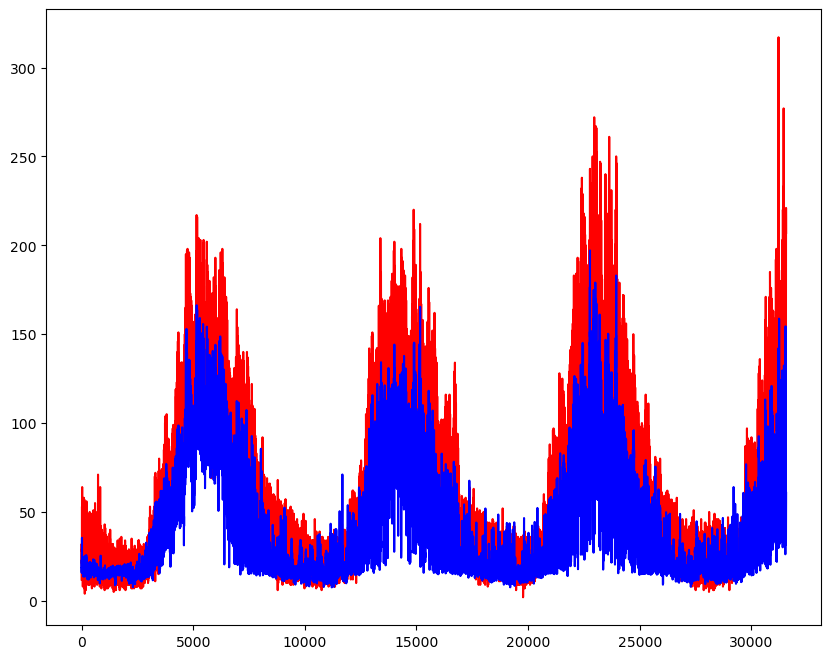

In [ ]:
## Visualising the results
plt.plot(true, color='red')
plt.plot(pred, color='blue')
plt.show()

In [ ]:
## 개선 후 재실행 예정
# best_model = tf.keras.models.load_model("../models/V2.h5", custom_objects={"TCN": TCN}, compile=False)
# y_preds = best_model.predict(ds_test)

# df_answer = pd.read_csv("../data/sample_submission.csv")
# df_answer.loc[:, ["wl_1018662" ,"wl_1018680", "wl_1018683", "wl_1019630"]] = y_preds
# df_answer.to_csv("../results/V2.csv", index=False)

In [ ]:
model_preds = pred
d_actual = true

from sklearn.metrics import mean_absolute_percentage_error
print('mean_absolute_percentage_error : ', mean_absolute_percentage_error(d_actual, model_preds))

from sklearn.metrics import mean_absolute_error
print('mean_absolute_error : ', mean_absolute_error(d_actual, model_preds))                                      

from sklearn.metrics import mean_squared_error
print('mean_squared_error : ', mean_squared_error(d_actual, model_preds))

from sklearn.metrics import r2_score   # model.score
print('r2_score : ', r2_score(d_actual, model_preds))

mean_absolute_percentage_error :  0.35818238712092043
mean_absolute_error :  25.24051821964717
mean_squared_error :  1364.4199053917257
r2_score :  0.480757723037746
